## How to run workflows using REANA client Python API

This Jupyter Notebook is a step by step guide on how to submit workflows to REANA using the client Python API. For more detailed information and code explanations please refer to the [blog post](https://blog.reana.io/posts/2021/reana-client-python-api/).

### Configuring access

In [1]:
import os

if not os.getenv('REANA_SERVER_URL'):
    os.environ['REANA_SERVER_URL'] = 'https://reana.cern.ch'

In [2]:
from getpass import getpass

my_reana_token = \
    os.getenv("REANA_ACCESS_TOKEN") or getpass('Enter your REANA token: ')

In [1]:
from reana_client.api.client import ping

ping(my_reana_token)

{'email': 'john.doe@example.org',
 'full_name': 'John Doe',
 'reana_server_version': '0.7.2',
 'reana_token': {'requested_at': 'Fri, 26 Feb 2021 13:00:00 GMT',
  'status': 'active',
  'value': 'my_reana_token'},
 'username': None,
 'status': 'Connected',
 'error': False}

### Specifying workflow

In [3]:
my_workflow_name = 'root6-roofit'
my_workflow_type = 'serial'

In [4]:
my_inputs = {
    'files': [
        'code/gendata.C',
        'code/fitdata.C'
    ],  # A list of files your analysis will be using
    'parameters': {
        'events': '20000',
        'data': 'results/data.root',
        'plot': 'results/plot.png',
    }  # Parameters for your workflow
}

In [5]:
my_workflow = {
    'steps': [
        {
            'name': 'gendata',
            'environment': 'reanahub/reana-env-root6:6.18.04',
            'commands': [
                'mkdir -p results && root -b -q \'code/gendata.C(${events},"${data}")\''
            ],
        },
        {
            'name': 'fitdata',
            'environment': 'reanahub/reana-env-root6:6.18.04',
            'commands': [
                'root -b -q \'code/fitdata.C("${data}","${plot}")\''
            ],
        },
    ]
}

### Creating workflow

In [6]:
from reana_client.api.client import create_workflow_from_json

create_workflow_from_json(
    workflow_json=my_workflow,
    name=my_workflow_name,
    access_token=my_reana_token,
    parameters=my_inputs,
    workflow_engine=my_workflow_type)

{'message': 'Workflow workspace created',
 'workflow_id': 'ce3204a6-5111-490a-8ed6-eaa7c83fc74d',
 'workflow_name': 'root6-roofit.1'}

### Uploading files

In [7]:
from reana_client.api.client import upload_to_server

abs_path_to_input_files = [os.path.abspath(f) for f in my_inputs['files']]
upload_to_server(my_workflow_name, abs_path_to_input_files, my_reana_token)

### Starting workflow

In [8]:
from reana_client.api.client import start_workflow

start_workflow(my_workflow_name, my_reana_token, {})

{'message': 'Workflow submitted.',
 'run_number': 1,
 'status': 'queued',
 'user': '00000000-0000-0000-0000-000000000000',
 'workflow_id': 'ce3204a6-5111-490a-8ed6-eaa7c83fc74d',
 'workflow_name': 'root6-roofit'}

### Checking workflow status

In [9]:
import time
from reana_client.api.client import get_workflow_status

while True:
    status_details = get_workflow_status(my_workflow_name, my_reana_token)
    print('Current status: ', status_details['status'])
    if status_details['status'] == 'finished':
        break
    time.sleep(1)

Current status:  running
Current status:  running
Current status:  running
Current status:  finished


### Checking workflow logs

In [10]:
import json
from reana_client.api.client import get_workflow_logs

workflow_logs = get_workflow_logs(my_workflow_name, my_reana_token, ['fitdata'])
job_logs = json.loads(workflow_logs['logs'])['job_logs']
fitdata_logs = job_logs[next(iter(job_logs))]['logs']

for item in fitdata_logs.split('\n')[-15:]:
    print(item)

ERR MATRIX APPROXIMATE
 PARAMETER  CORRELATION COEFFICIENTS  
       NO.  GLOBAL      1      2      3      4      5
        1  0.00000   1.000  0.000  0.000  0.000  0.000
        2  0.00000   0.000  1.000  0.000  0.000  0.000
        3  0.00000   0.000  0.000  1.000  0.000  0.000
        4  0.00000   0.000  0.000  0.000  1.000  0.000
        5  0.00000   0.000  0.000  0.000  0.000  1.000
 ERR MATRIX APPROXIMATE
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
Info in <TCanvas::Print>: png file results/plot.png has been created


### Listing workspace files

In [11]:
from reana_client.api.client import list_files

list_files(my_workflow_name, my_reana_token)

[{'last-modified': '2021-02-25T13:36:17',
  'name': 'results/data.root',
  'size': 154457},
 {'last-modified': '2021-02-25T13:36:24',
  'name': 'results/plot.png',
  'size': 15450},
 {'last-modified': '2021-02-25T13:35:50',
  'name': 'code/gendata.C',
  'size': 1937},
 {'last-modified': '2021-02-25T13:35:50',
  'name': 'code/fitdata.C',
  'size': 1648}]

### Downloading outputs

In [12]:
from reana_client.api.client import download_file

output_filename = 'results/plot.png'
file_binary_blob = download_file(
    my_workflow_name, output_filename, my_reana_token)

### Displaying output images

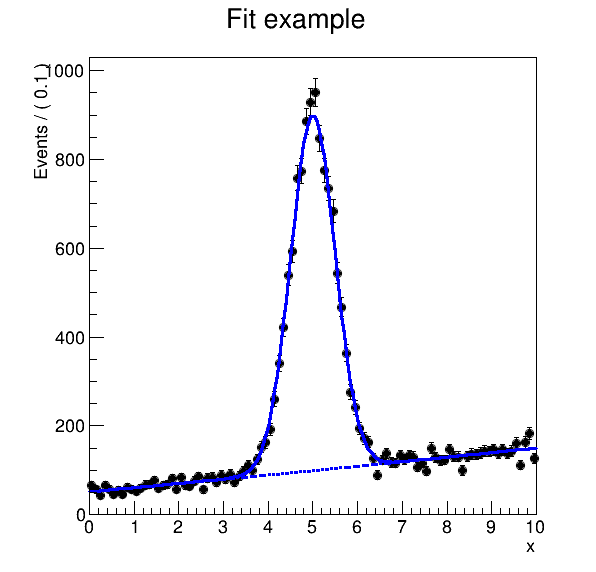

In [13]:
from PIL import Image
import io

image_stream = io.BytesIO(file_binary_blob)
Image.open(image_stream)